In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import glob as gb
import os
import matplotlib.dates as mdates
from cycler import cycler
from collections import OrderedDict

%matplotlib notebook

In [33]:
# Load HDF file
folder = 'T2_d20_water'
data_folder = '../Data/'
df = pd.HDFStore(data_folder + str(folder) +'/drop5.h5')['df']

# Create column for time since start of measurement
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

df.head()
# df.info()

,datetime,chip,concentration,current,flow_rate,fs,humidity,measurementID,medium,optical power,run_time,sample_no,sweep_no,t_in,t_out,tempC,A,tau,c,delta
0,2016-08-25 12:27:30.249666,T2,0.0,0.5,1,0.0001,51.17,1.472124e+09,D2O (%),0.000236,5,1000,1,23.25,23.0,23.62,1.033025,12.375511,0.000812,0.000000
1,2016-08-25 12:27:30.673709,T2,0.0,0.5,1,0.0001,51.17,1.472124e+09,D2O (%),0.000236,5,1000,2,23.25,23.0,23.62,1.022731,12.387995,0.000504,0.007067
2,2016-08-25 12:27:30.973739,T2,0.0,0.5,1,0.0001,51.17,1.472124e+09,D2O (%),0.000236,5,1000,3,23.25,23.0,23.62,1.031506,12.367767,-0.000243,0.012068
3,2016-08-25 12:27:31.194761,T2,0.0,0.5,1,0.0001,51.17,1.472124e+09,D2O (%),0.000236,5,1000,4,23.25,23.0,23.62,1.029140,12.389922,0.001907,0.015752
4,2016-08-25 12:27:31.370779,T2,0.0,0.5,1,0.0001,51.17,1.472124e+09,D2O (%),0.000236,5,1000,5,23.25,23.0,23.62,1.029154,12.388621,0.000358,0.018685


# Real time raw data

In [5]:
grouped = df.groupby(['concentration'])

<IPython.core.display.Javascript object>


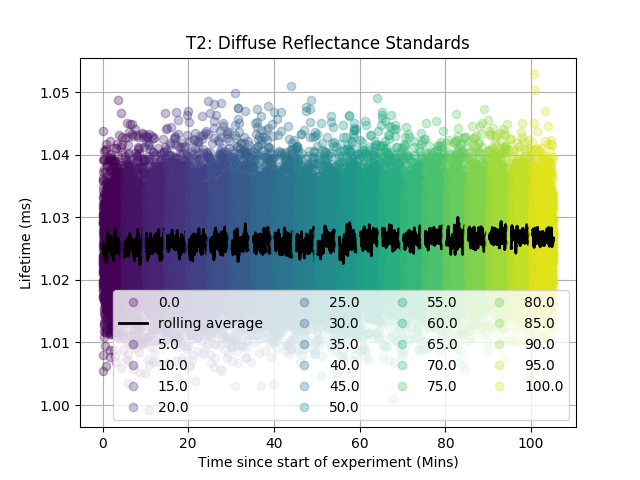

In [29]:
# Create colormap for plotting
n = len(df.concentration.unique()) # Number of colors
new_colors = [plt.get_cmap('viridis')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# All in one
fig, ax = plt.subplots()

for key, group in grouped:
    ax.plot(group['delta'], group['A'], 'o', alpha=0.3, label=key)
    rolling = group['A'].rolling(window=50).mean()
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

plt.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), ncol=4)
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Lifetime (ms)')
plt.title('{}: Diffuse Reflectance Standards'.format(df.chip.unique()[0]))
# plt.savefig(data_folder +  str(folder) + '/lifetimeVsTime.png', dpi=500)

In [8]:
df = df[df.sweep_no > 600]

In [9]:
# Number of measurements
max(df['sweep_no']) - min(df['sweep_no'])

897

## tau & A vs concentration

In [10]:
# Apply mean and std functions to all collumns
g = grouped.agg([np.mean, np.std])
g = g.reset_index()

In [11]:
r = g['concentration']
r = np.linspace(1.07, 97.29, num=21, endpoint=True)

<IPython.core.display.Javascript object>


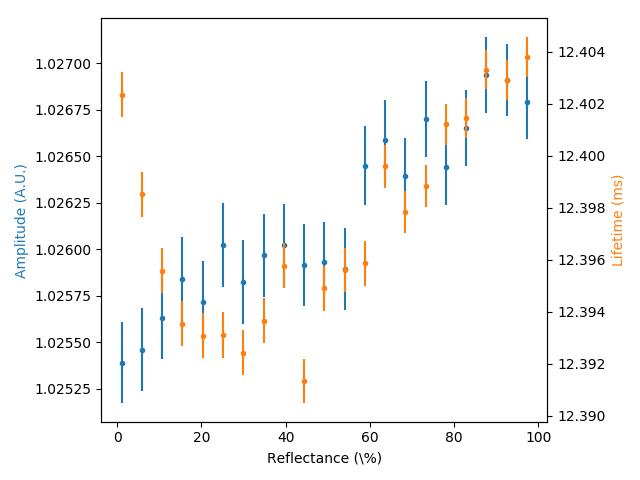

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.errorbar(r, g['A']['mean'], yerr=g['A']['std']/np.sqrt(897), fmt='.', ls='')
c = ax1._get_lines.get_next_color()
ax2.errorbar(r, g['tau']['mean'], yerr=g['tau']['std']/np.sqrt(897), fmt='.', ls='', color=c)

ax1.set_xlabel('Reflectance (\%)')
ax2.set_ylabel('Lifetime (ms)', color='#ff7f0e')
ax1.set_ylabel('Amplitude (A.U.)', color='#1f77b4')

# ax1.grid()
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
ax2.ticklabel_format(useOffset=False, axis='y')

# plt.savefig(data_folder + str(folder) + '/T2_d2o_Water')

In [12]:
z = np.polyfit(g['concentration'], g['tau']['mean'], deg=2)
p = np.poly1d(z)
xp = np.linspace(0, 100, 1000)
yp = p(xp)
z

array([  8.62012381e-06,  -2.58547003e-04,   1.20260868e+01])

<IPython.core.display.Javascript object>


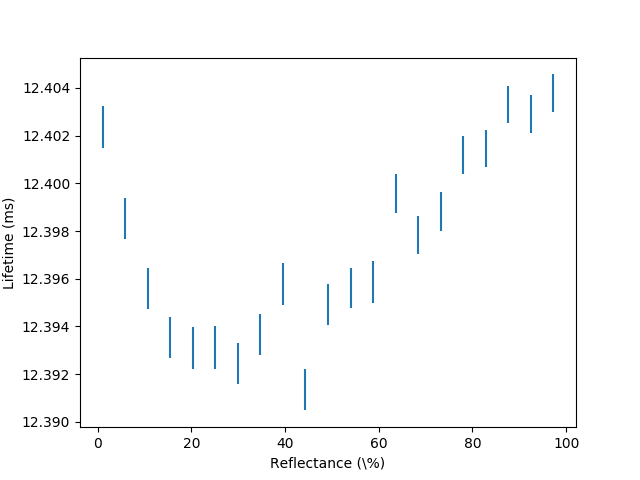

In [15]:
std = g['tau']['std']
sem = std/np.sqrt(897)

# Plotting SEM!!!!
fig, ax1 = plt.subplots()
ax1.errorbar(r, g['tau']['mean'], yerr=sem,  fmt='', ls='') #, markeredgewidth=0.5, ms=3
# ax1.plot(xp, yp, '-', lw=2)

ax1.set_xlabel('Reflectance (\%)')
ax1.set_ylabel('Lifetime (ms)')

# ax1.grid()
ax1.ticklabel_format(useOffset=False, axis='y')

plt.savefig(data_folder + str(folder) + '/T2_d2o_Water')

# Miscellaneous
## Journal plotting

In [2]:
# Set figure size
WIDTH = 246.0  # the number (in pt) latex spits out when typing: \the\linewidth
FACTOR = 0.9  # the fraction of the width you'd like the figure to occupy
fig_width_pt = WIDTH * FACTOR

inches_per_pt = 1.0 / 72.27
golden_ratio = (np.sqrt(5) - 1.0) / 2.0  # because it looks good

fig_width_in = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio  # figure height in inches
fig_dims = [fig_width_in, fig_height_in]  # fig dims as a list

# Update rcParams for figure size
params = {
    'font.size': 9.0,
    'text.usetex': True,
    'savefig.dpi': 1200,
    'savefig.format': 'pdf',
    'savefig.bbox': 'tight',
    'figure.figsize': fig_dims,
}
plt.rcParams.update(params)

## Each concentration vs lifetime (Rolling Mean)

<IPython.core.display.Javascript object>


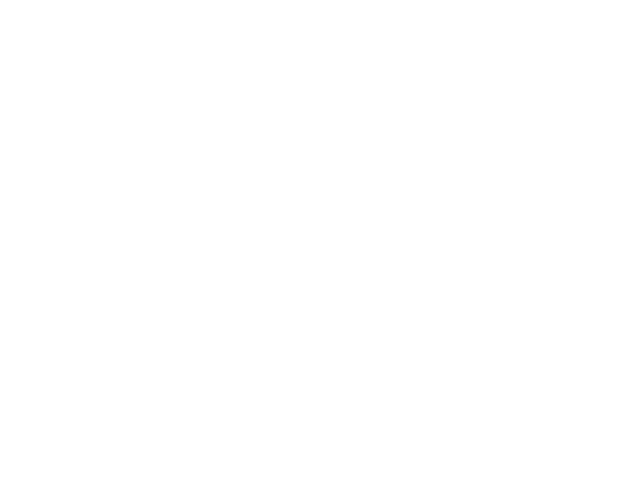

<IPython.core.display.Javascript object>


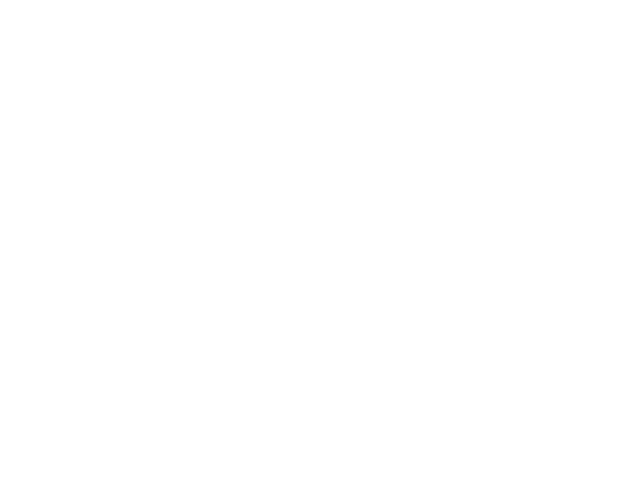

<IPython.core.display.Javascript object>


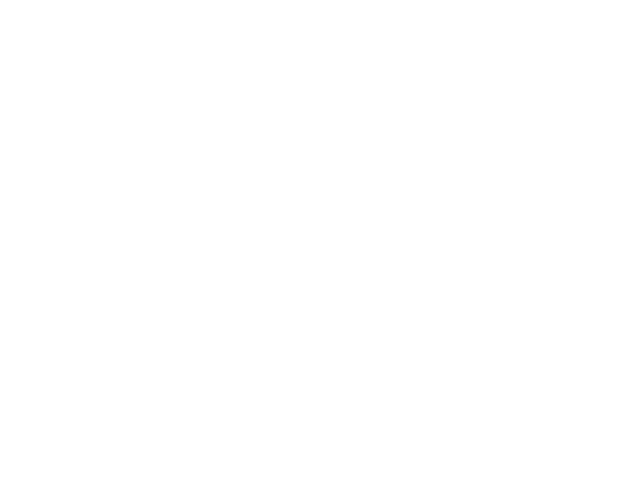

<IPython.core.display.Javascript object>


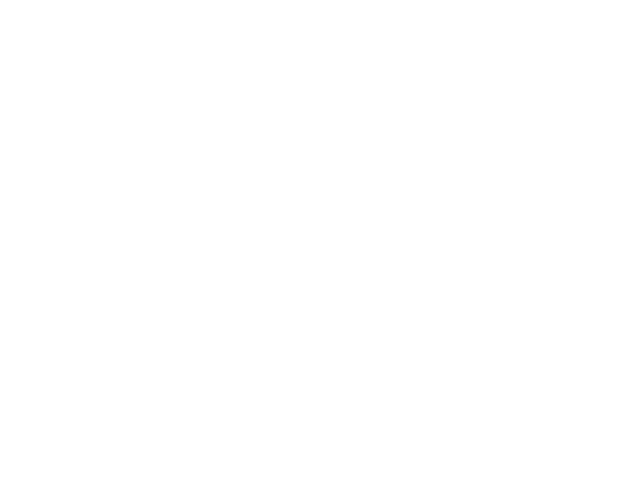

<IPython.core.display.Javascript object>


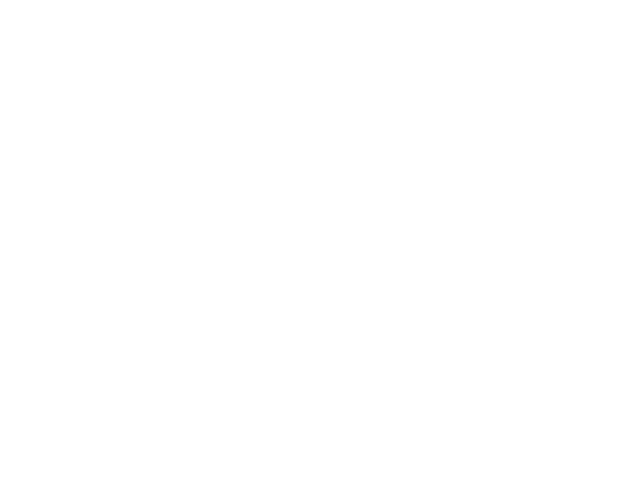

<IPython.core.display.Javascript object>


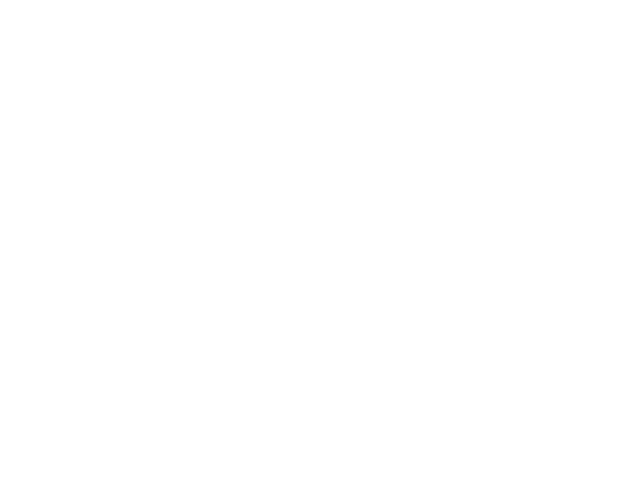

<IPython.core.display.Javascript object>


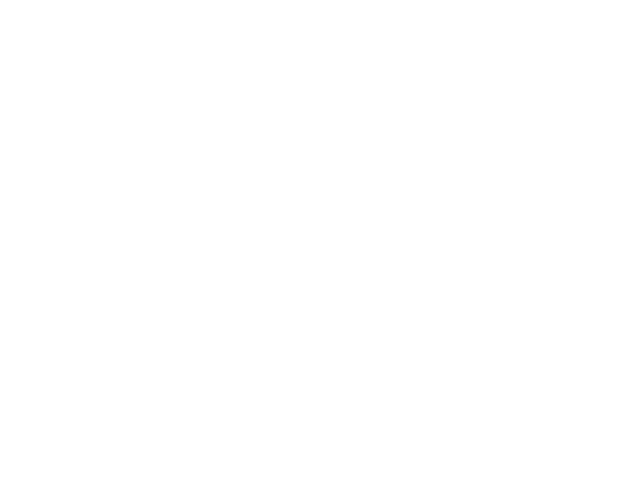

<IPython.core.display.Javascript object>


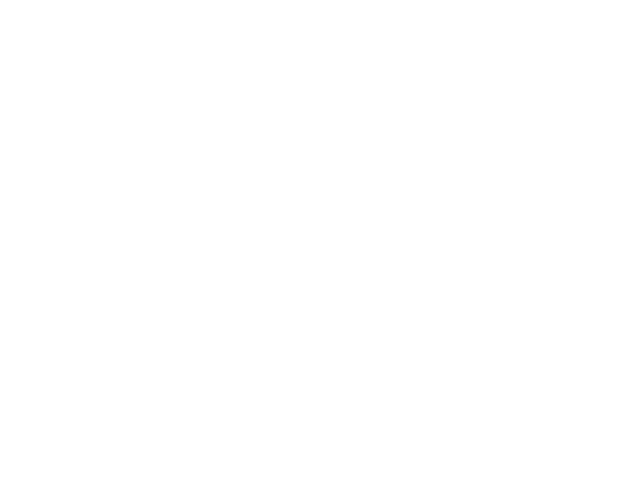

<IPython.core.display.Javascript object>


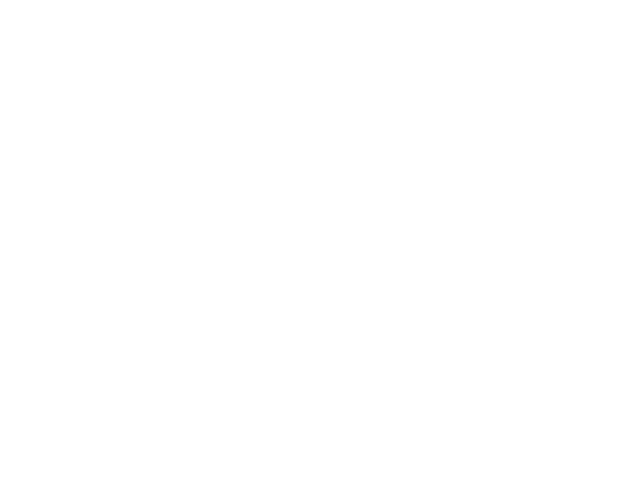

<IPython.core.display.Javascript object>


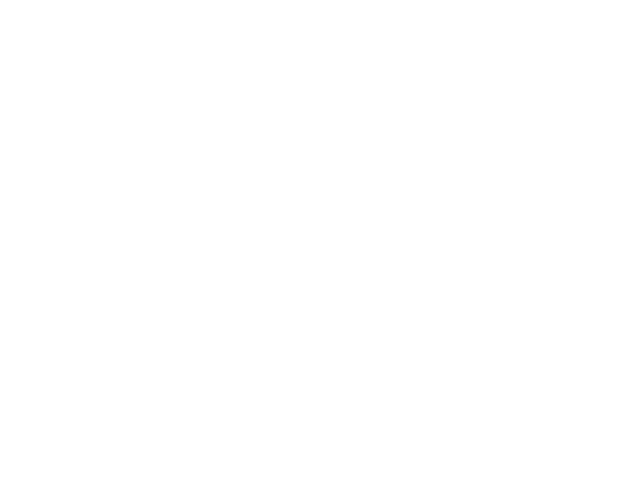

SystemError: <built-in method write of _io.BufferedWriter object at 0x000000000B011F68> returned a result with an error set

In [12]:
# Individual plots

# Make directory to store files
directory = data_folder + str(folder) + '/individual/'
if not os.path.exists(directory):
    os.makedirs(directory)

for key, group in grouped:
    plt.figure()
    plt.ticklabel_format(useOffset=False, axis='y')
    plt.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50, center=True).mean()
    plt.plot(group['delta'], rolling, '.', lw=3, color='red', label='rolling mean ({k})'.format(k=key)) 
    plt.title('Concentration is {} %'.format(key))
    plt.grid()
    plt.xlabel('Time since start of experiment (Mins)')
    plt.ylabel('Lifetime (ms)')
    plt.legend()
    plt.savefig(data_folder + str(folder) + '/individual/' + str(key) + '.png', dpi=200)

In [13]:
plt.close("all")